Iñigo Martin Melero

## Participante 3

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_3_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


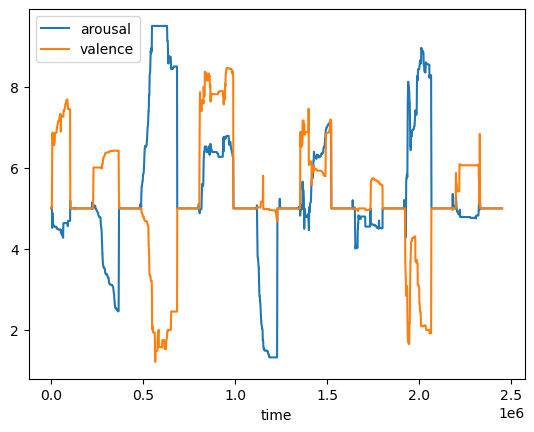

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_3_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.958  35.566  23.537  29.284  24.664     8.477     8.683   
1              1  0.977  35.701  23.526  29.313  24.671     8.682     8.766   
2              2  0.997  35.837  23.514  29.342  24.678     8.888     8.848   
3              3  1.017  35.963  23.482  29.400  24.698     9.134     9.093   
4              4  0.988  35.696  23.517  29.343  24.688     9.095     8.973   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.925  35.899  31.804  30.417  24.110    18.049     6.960   
2451580  2451580  0.912  36.059  31.696  30.427  24.113    18.170     7.082   
2451581  2451581  0.905  36.214  31.734  30.446  24.117    18.212     7.123   
2451582  2451582  0.882  36.254  31.738  30.437  24.106    17.968     7.002   
2451583  2451583  0.889  35.929  31.781  30.437  24.103    17.925     7.041   

         emg_trap  video  
0           6.876     10

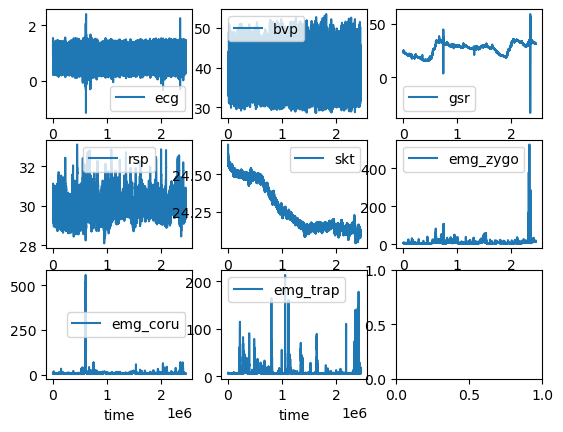

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

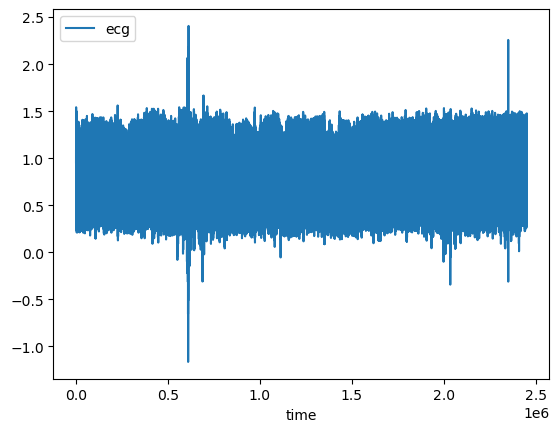

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

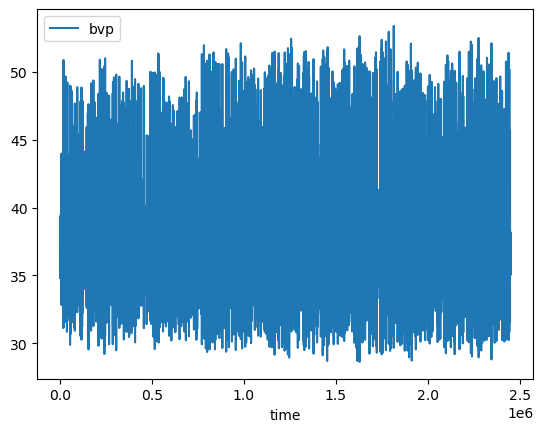

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

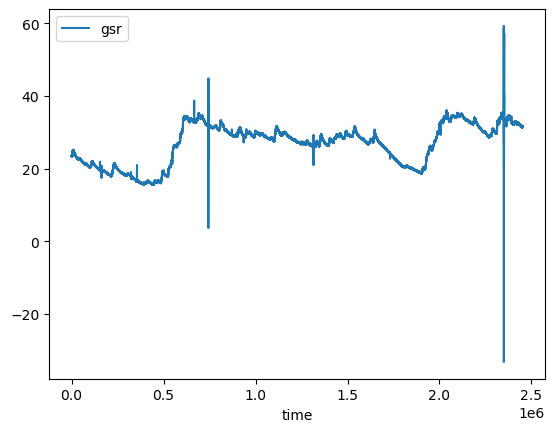

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

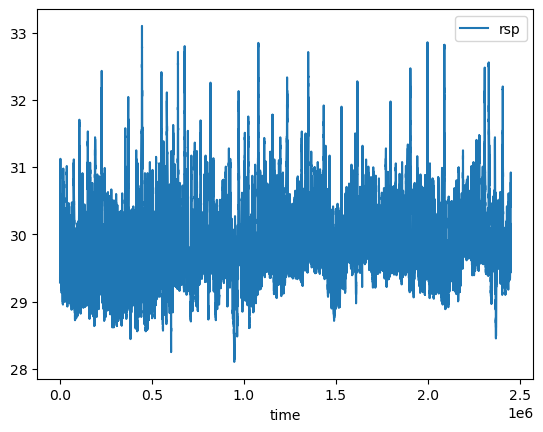

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

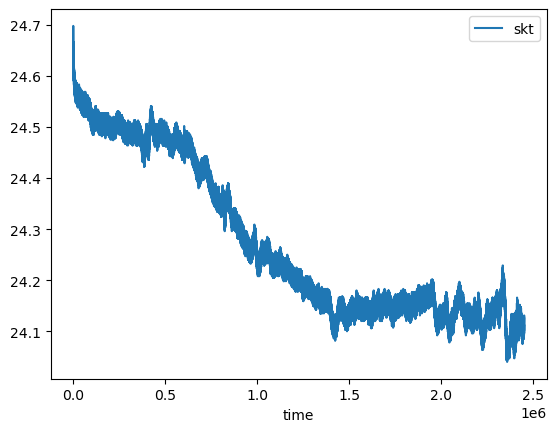

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

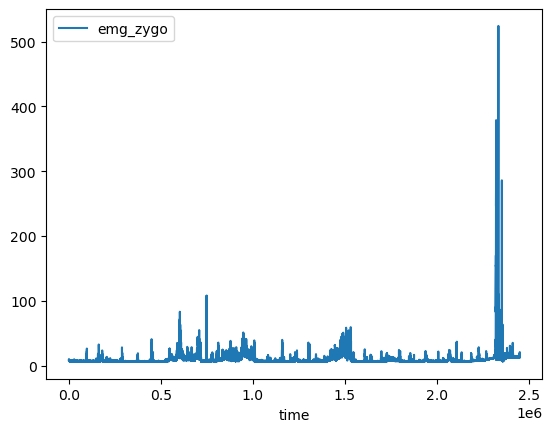

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

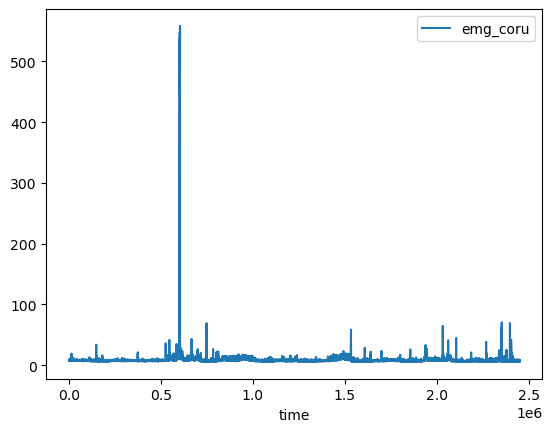

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

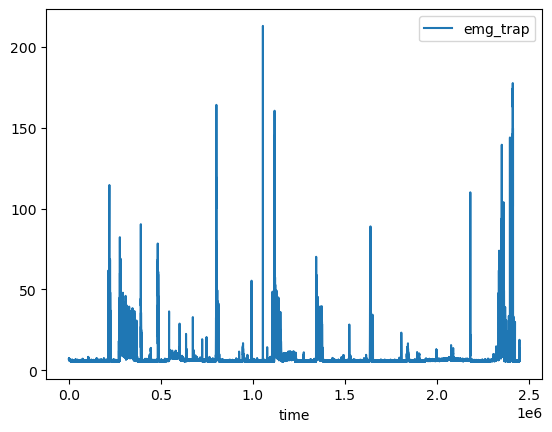

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

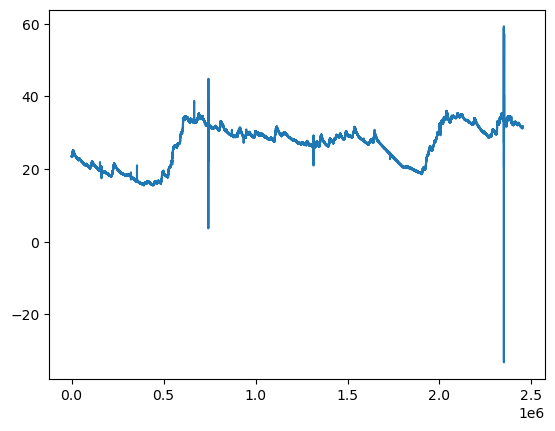

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

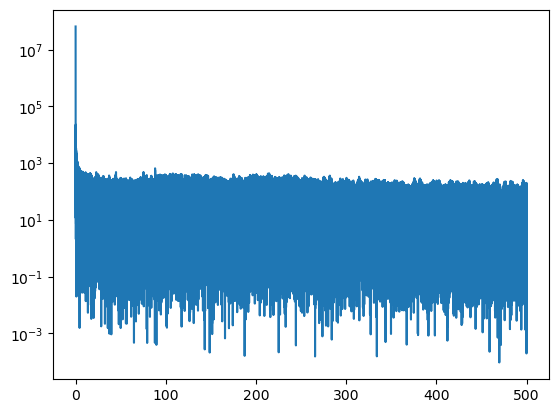

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

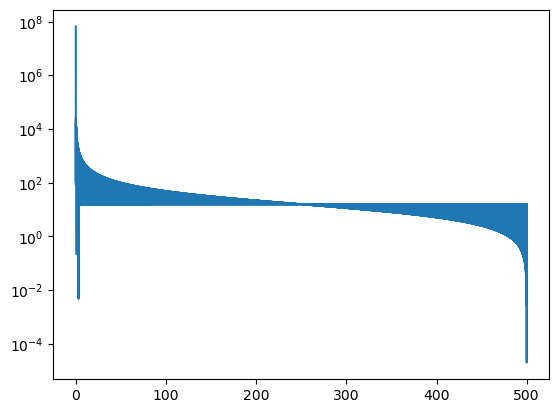

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

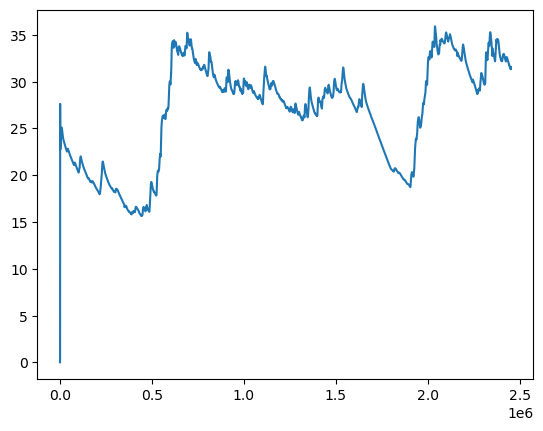

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  31.572
2451580  31.572
2451581  31.572
2451582  31.573
2451583  31.573

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

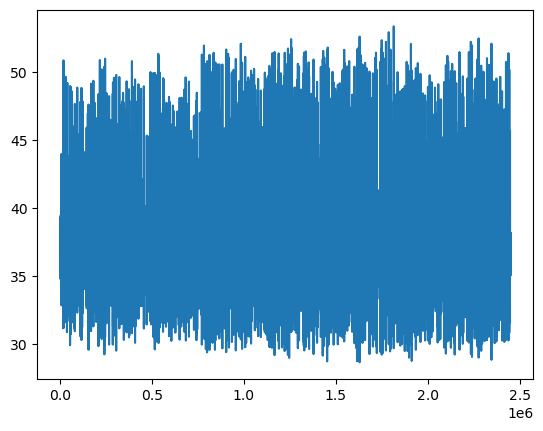

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

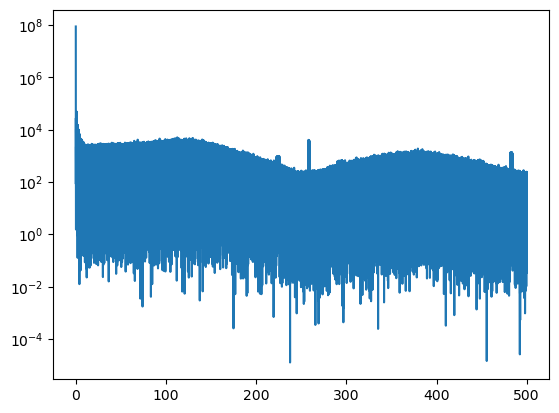

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

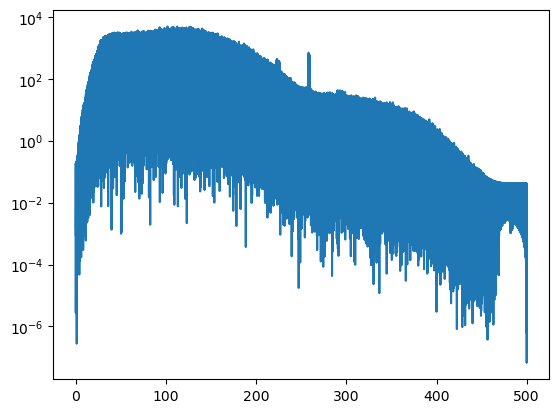

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

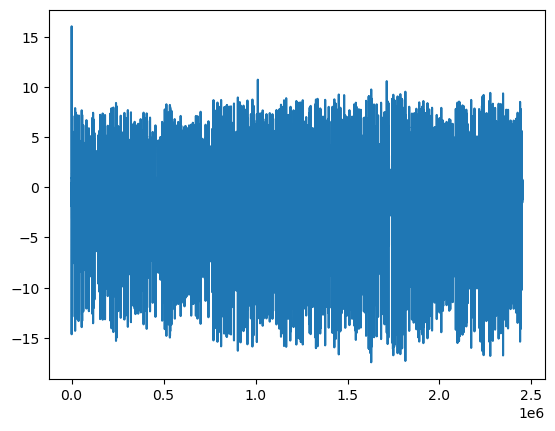

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        37.988
1        42.517
2        49.996
3        53.113
4        46.094
...         ...
2451579  37.042
2451580  37.100
2451581  37.091
2451582  37.051
2451583  37.060

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

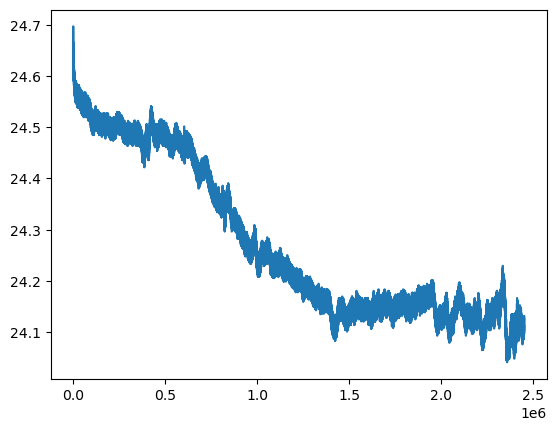

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

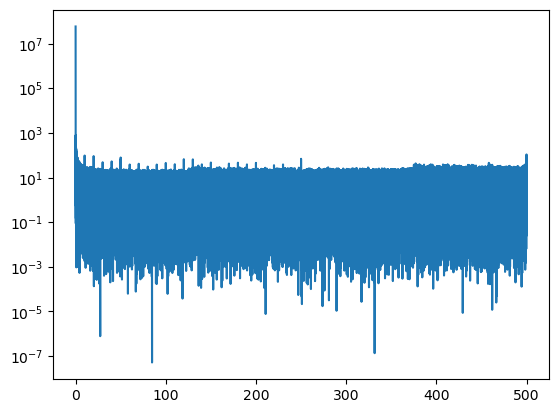

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

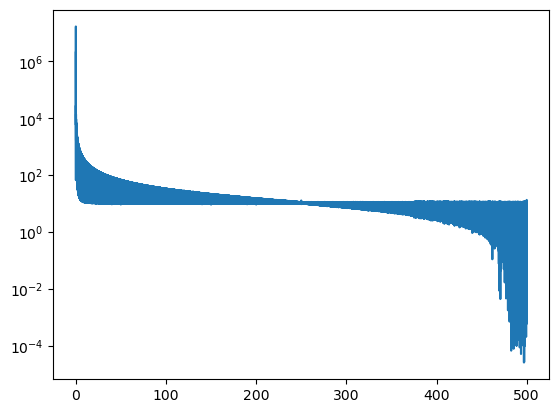

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

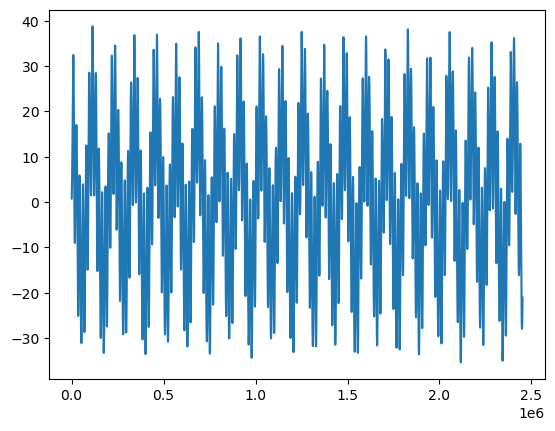

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.790
1        40.791
2        40.791
3        40.791
4        40.791
...         ...
2451579  18.895
2451580  18.899
2451581  18.903
2451582  18.907
2451583  18.911

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.958  29.284     8.477     8.683     6.876     10
1              1  0.977  29.313     8.682     8.766     7.040     10
2              2  0.997  29.342     8.888     8.848     7.204     10
3              3  1.017  29.400     9.134     9.093     7.450     10
4              4  0.988  29.343     9.095     8.973     7.290     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.925  30.417    18.049     6.960     6.262     12
2451580  2451580  0.912  30.427    18.170     7.082     6.302     12
2451581  2451581  0.905  30.446    18.212     7.123     6.343     12
2451582  2451582  0.882  30.437    17.968     7.002     6.262     12
2451583  2451583  0.889  30.437    17.925     7.041     6.302     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.958  29.284     8.477     8.683     6.876     10  37.988   
1              1  0.977  29.313     8.682     8.766     7.040     10  42.517   
2              2  0.997  29.342     8.888     8.848     7.204     10  49.996   
3              3  1.017  29.400     9.134     9.093     7.450     10  53.113   
4              4  0.988  29.343     9.095     8.973     7.290     10  46.094   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.925  30.417    18.049     6.960     6.262     12  37.042   
2451580  2451580  0.912  30.427    18.170     7.082     6.302     12  37.100   
2451581  2451581  0.905  30.446    18.212     7.123     6.343     12  37.091   
2451582  2451582  0.882  30.437    17.968     7.002     6.262     12  37.051   
2451583  2451583  0.889  30.437    17.925     7.041     6.302     12  37.060   

            gsr     skt  
0         0.000  40.790  
1         0.000  40.791  
2         0.000  40.791  
3         0.000  40.791  
4         0.000  40.791  
...         ...     ...  
2451579  31.572  18.895  
2451580  31.572  18.899  
2451581  31.572  18.903  
2451582  31.573  18.907  
2451583  31.573  18.911  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.552101  0.613430  0.129812  0.787167  0.421806  0.001654   
221502    221502  0.561064  0.616961  0.129863  0.787098  0.423700  0.001978   
221503    221503  0.559384  0.617980  0.129863  0.787014  0.421595  0.001871   
221504    221504  0.563025  0.617106  0.129863  0.786944  0.429804  0.002198   
221505    221505  0.563025  0.616379  0.129914  0.786861  0.427910  0.001764   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.540056  0.612702  0.905879  0.358116  0.816881  0.018385   
2331580  2331580  0.542857  0.612375  0.905879  0.358200  0.798779  0.017841   
2331581  2331581  0.550980  0.611319  0.905828  0.358283  0.800674  0.017835   
2331582  2331582  0.550980  0.612557  0.905828  0.358353  0.796674  0.017506   
2331583  2331583  0.544818  0.614704  0.905828  0.358437  0.800674  0.017940   

         emg_coru  emg_trap  video  
221501   0.002380  0.183754      5  
221502   0.002452  0.181636      5  
221503   0.002452  0.176376      5  
221504   0.002747  0.172925      5  
221505   0.002456  0.166346      5  
...           ...       ...    ...  
2331579  0.003345  0.012142      6  
2331580  0.003124  0.011620      6  
2331581  0.003122  0.011350      6  
2331582  0.003048  0.010822      6  
2331583  0.003048  0.011079      6  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.552101  0.613430  0.129812  0.421806  0.787167  0.001654   
221502    221502  0.561064  0.616961  0.129863  0.423700  0.787098  0.001978   
221503    221503  0.559384  0.617980  0.129863  0.421595  0.787014  0.001871   
221504    221504  0.563025  0.617106  0.129863  0.429804  0.786944  0.002198   
221505    221505  0.563025  0.616379  0.129914  0.427910  0.786861  0.001764   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.540056  0.612702  0.905879  0.816881  0.358116  0.018385   
2331580  2331580  0.542857  0.612375  0.905879  0.798779  0.358200  0.017841   
2331581  2331581  0.550980  0.611319  0.905828  0.800674  0.358283  0.017835   
2331582  2331582  0.550980  0.612557  0.905828  0.796674  0.358353  0.017506   
2331583  2331583  0.544818  0.614704  0.905828  0.800674  0.358437  0.017940   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.557703  0.613030  0.130169  0.419701  0.785732  0.001654  0.002380   
221540   0.553782  0.611938  0.130526  0.429804  0.784227  0.001761  0.002378   
221560   0.548459  0.618126  0.130832  0.425805  0.782723  0.002094  0.001935   
221580   0.548459  0.610955  0.131188  0.425805  0.781204  0.001984  0.001935   
221600   0.542857  0.613285  0.131545  0.429804  0.779685  0.002201  0.001931   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.551261  0.612411  0.906236  0.825089  0.351721  0.021468  0.003194   
2331520  0.552941  0.610227  0.906134  0.820880  0.353351  0.018490  0.002898   
2331540  0.543697  0.612994  0.906083  0.808882  0.354967  0.022127  0.002823   
2331560  0.540896  0.611829  0.905981  0.808672  0.356584  0.021908  0.003565   
2331580  0.542857  0.612375  0.905879  0.798779  0.358200  0.017841  0.003124   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.557703  0.613030  0.130169  0.419701  0.785732  0.001654  0.002380   
1      0.553782  0.611938  0.130526  0.429804  0.784227  0.001761  0.002378   
2      0.548459  0.618126  0.130832  0.425805  0.782723  0.002094  0.001935   
3      0.548459  0.610955  0.131188  0.425805  0.781204  0.001984  0.001935   
4      0.542857  0.613285  0.131545  0.429804  0.779685  0.002201  0.001931   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.551261  0.612411  0.906236  0.825089  0.351721  0.021468  0.003194   
63500  0.552941  0.610227  0.906134  0.820880  0.353351  0.018490  0.002898   
63501  0.543697  0.612994  0.906083  0.808882  0.354967  0.022127  0.002823   
63502  0.540896  0.611829  0.905981  0.808672  0.356584  0.021908  0.003565   
63503  0.542857  0.612375  0.905879  0.798779  0.358200  0.017841  0.003124   

       emg_trap  valence  arousal  
0      0.105502    5.000    5.041  
1      0.166494    5.000    5.041  
2      0.131157    5.000    5.041  
3      0.135651    5.000    5.041  
4      0.182189    5.000    5.041  
...         ...      ...      ...  
63499  0.016107    5.074    5.041  
63500  0.014781    5.074    5.041  
63501  0.013468    5.073    5.038  
63502  0.013197    5.072    5.037  
63503  0.011620    5.073    5.039  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.557703  0.613030  0.130169  0.419701  0.785732  0.001654  0.002380   
1      0.553782  0.611938  0.130526  0.429804  0.784227  0.001761  0.002378   
2      0.548459  0.618126  0.130832  0.425805  0.782723  0.002094  0.001935   
3      0.548459  0.610955  0.131188  0.425805  0.781204  0.001984  0.001935   
4      0.542857  0.613285  0.131545  0.429804  0.779685  0.002201  0.001931   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.535294  0.614268  0.906644  0.847401  0.345228  0.020581  0.003196   
63496  0.545658  0.615105  0.906542  0.841507  0.346858  0.024334  0.003272   
63497  0.540056  0.612666  0.906440  0.833088  0.348474  0.024878  0.002974   
63498  0.545658  0.585041  0.906338  0.827194  0.350105  0.025875  0.003050   
63499  0.551261  0.612411  0.906236  0.825089  0.351721  0.021468  0.003194   

       emg_trap  valence  arousal  
0      0.105502    5.000    5.041  
1      0.166494    5.000    5.041  
2      0.131157    5.000    5.041  
3      0.135651    5.000    5.041  
4      0.182189    5.000    5.041  
...         ...      ...      ...  
63495  0.015573    5.074    5.042  
63496  0.016107    5.073    5.038  
63497  0.017685    5.072    5.036  
63498  0.017697    5.073    5.038  
63499  0.016107    5.074    5.041  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.557703  0.613030  0.130169  0.419701  0.785732  0.001654  0.002380   
 1   0.553782  0.611938  0.130526  0.429804  0.784227  0.001761  0.002378   
 2   0.548459  0.618126  0.130832  0.425805  0.782723  0.002094  0.001935   
 3   0.548459  0.610955  0.131188  0.425805  0.781204  0.001984  0.001935   
 4   0.542857  0.613285  0.131545  0.429804  0.779685  0.002201  0.001931   
 5   0.548179  0.613212  0.131902  0.442012  0.778180  0.002415  0.002005   
 6   0.542857  0.614304  0.132310  0.433803  0.776662  0.002311  0.001859   
 7   0.542857  0.611101  0.132667  0.435908  0.775143  0.002418  0.001857   
 8   0.538095  0.609827  0.133024  0.435908  0.773624  0.002201  0.001857   
 9   0.540896  0.617361  0.133381  0.431909  0.772091  0.001981  0.002080   
 10  0.540056  0.625077  0.133738  0.425805  0.770559  0.001322  0.001636   
 11  0.540896  0.613103  0.134146  0.429804  0.769040  0.001761  0.001562   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.557703  0.613030  0.130169  0.419701  0.785732  0.001654  0.002380   
1     0.546499  0.612375  0.138989  0.392970  0.747527  0.002418  0.002749   
2     0.548179  0.616779  0.146535  0.309619  0.709099  0.002418  0.002230   
3     0.552101  0.616997  0.152960  0.279099  0.671729  0.002421  0.001783   
4     0.550140  0.614268  0.158109  0.250684  0.636547  0.005061  0.001558   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.583193  0.614813  0.907204  0.287097  0.171687  0.011115  0.001783   
2536  0.573109  0.615869  0.909091  0.380972  0.201045  0.009249  0.001785   
2537  0.553782  0.613867  0.910162  0.545990  0.235070  0.011120  0.002081   
2538  0.437815  0.611975  0.910060  0.729320  0.272732  0.010021  0.001937   
2539  0.527171  0.611720  0.908581  0.922964  0.312665  0.009573  0.002007   

             8         9        10  ...       193       194       195  \
0     0.105502  0.553782  0.611938  ...  0.547339  0.615541  0.138633   
1     0.105187  0.550140  0.616742  ...  0.552941  0.615396  0.146281   
2     0.201741  0.548179  0.612266  ...  0.553782  0.611865  0.152705   
3     0.159683  0.550140  0.612666  ...  0.553782  0.612666  0.157956   
4     0.119459  0.547339  0.611720  ...  0.551821  0.615505  0.162086   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.012135  0.566667  0.613722  ...  0.598880  0.614595  0.909040   
2536  0.010030  0.550980  0.615323  ...  0.550140  0.616124  0.910111   
2537  0.011878  0.552941  0.613139  ...  0.424930  0.611683  0.910111   
2538  0.024316  0.526050  0.613576  ...  0.538095  0.618344  0.908683   
2539  0.026150  0.533613  0.618198  ...  0.551261  0.612411  0.906236   

           196       197       198       199       200  valence  arousal  
0     0.392970  0.749073  0.002858  0.002749  0.111831  5.00000  5.03608  
1     0.315723  0.710617  0.003185  0.002226  0.202687  5.00000  5.00128  
2     0.287308  0.673192  0.002528  0.001929  0.122685  5.00000  5.07084  
3     0.258682  0.637899  0.005611  0.001929  0.121848  5.00000  5.05448  
4     0.223953  0.605643  0.005064  0.001633  0.117341  5.00000  5.00012  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.372764  0.199777  0.010678  0.001187  0.010809  5.10524  5.09160  
2536  0.541781  0.233635  0.010125  0.002081  0.011350  5.99680  5.04052  
2537  0.721111  0.271172  0.010016  0.002228  0.024296  6.83512  4.99912  
2538  0.916860  0.311035  0.009471  0.002230  0.024837  6.61100  4.99028  
2539  0.825089  0.351721  0.021468  0.003194  0.016107  5.19300  5.05716  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.557703  0.613030  0.130169  0.419701  0.785732  0.001654  0.002380   
1     0.546499  0.612375  0.138989  0.392970  0.747527  0.002418  0.002749   
2     0.548179  0.616779  0.146535  0.309619  0.709099  0.002418  0.002230   
3     0.552101  0.616997  0.152960  0.279099  0.671729  0.002421  0.001783   
4     0.550140  0.614268  0.158109  0.250684  0.636547  0.005061  0.001558   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.583193  0.614813  0.907204  0.287097  0.171687  0.011115  0.001783   
2536  0.573109  0.615869  0.909091  0.380972  0.201045  0.009249  0.001785   
2537  0.553782  0.613867  0.910162  0.545990  0.235070  0.011120  0.002081   
2538  0.437815  0.611975  0.910060  0.729320  0.272732  0.010021  0.001937   
2539  0.527171  0.611720  0.908581  0.922964  0.312665  0.009573  0.002007   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub3.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.557703  0.613030  0.130169  0.419701  0.785732  0.001654  0.002380   
1     0.546499  0.612375  0.138989  0.392970  0.747527  0.002418  0.002749   
2     0.548179  0.616779  0.146535  0.309619  0.709099  0.002418  0.002230   
3     0.552101  0.616997  0.152960  0.279099  0.671729  0.002421  0.001783   
4     0.550140  0.614268  0.158109  0.250684  0.636547  0.005061  0.001558   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.583193  0.614813  0.907204  0.287097  0.171687  0.011115  0.001783   
2536  0.573109  0.615869  0.909091  0.380972  0.201045  0.009249  0.001785   
2537  0.553782  0.613867  0.910162  0.545990  0.235070  0.011120  0.002081   
2538  0.437815  0.611975  0.910060  0.729320  0.272732  0.010021  0.001937   
2539  0.527171  0.611720  0.908581  0.922964  0.312665  0.009573  0.002007   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub3.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.557703  0.613030  0.130169  0.419701  0.785732  0.001654  0.002380   
1     0.546499  0.612375  0.138989  0.392970  0.747527  0.002418  0.002749   
2     0.548179  0.616779  0.146535  0.309619  0.709099  0.002418  0.002230   
3     0.552101  0.616997  0.152960  0.279099  0.671729  0.002421  0.001783   
4     0.550140  0.614268  0.158109  0.250684  0.636547  0.005061  0.001558   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.583193  0.614813  0.907204  0.287097  0.171687  0.011115  0.001783   
2536  0.573109  0.615869  0.909091  0.380972  0.201045  0.009249  0.001785   
2537  0.553782  0.613867  0.910162  0.545990  0.235070  0.011120  0.002081   
2538  0.437815  0.611975  0.910060  0.729320  0.272732  0.010021  0.001937   
2539  0.527171  0.611720  0.908581  0.922964  0.312665  0.009573  0.002007   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub3.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.557703  0.613030  0.130169  0.419701  0.785732  0.001654  0.002380   
1     0.546499  0.612375  0.138989  0.392970  0.747527  0.002418  0.002749   
2     0.548179  0.616779  0.146535  0.309619  0.709099  0.002418  0.002230   
3     0.552101  0.616997  0.152960  0.279099  0.671729  0.002421  0.001783   
4     0.550140  0.614268  0.158109  0.250684  0.636547  0.005061  0.001558   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.583193  0.614813  0.907204  0.287097  0.171687  0.011115  0.001783   
2536  0.573109  0.615869  0.909091  0.380972  0.201045  0.009249  0.001785   
2537  0.553782  0.613867  0.910162  0.545990  0.235070  0.011120  0.002081   
2538  0.437815  0.611975  0.910060  0.729320  0.272732  0.010021  0.001937   
2539  0.527171  0.611720  0.908581  0.922964  0.312665  0.009573  0.002007   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub3.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.557703  0.613030  0.130169  0.419701  0.785732  0.001654  0.002380   
1     0.546499  0.612375  0.138989  0.392970  0.747527  0.002418  0.002749   
2     0.548179  0.616779  0.146535  0.309619  0.709099  0.002418  0.002230   
3     0.552101  0.616997  0.152960  0.279099  0.671729  0.002421  0.001783   
4     0.550140  0.614268  0.158109  0.250684  0.636547  0.005061  0.001558   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.583193  0.614813  0.907204  0.287097  0.171687  0.011115  0.001783   
2536  0.573109  0.615869  0.909091  0.380972  0.201045  0.009249  0.001785   
2537  0.553782  0.613867  0.910162  0.545990  0.235070  0.011120  0.002081   
2538  0.437815  0.611975  0.910060  0.729320  0.272732  0.010021  0.001937   
2539  0.527171  0.611720  0.908581  0.922964  0.312665  0.009573  0.002007   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub3.csv', index=False)